In [1]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning==1.2.7

In [2]:
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [3]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

In [4]:
news_summary=pd.read_csv("news_summary.csv",encoding="ISO-8859-1")
#news_summary_more=pd.read_csv("news_summary_more.csv",encoding="ISO-8859-1")

In [5]:
news_summary.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
news_summary = news_summary[['text', 'ctext']]
news_summary.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
news_summary.columns = ['summary', 'text']
news_summary = news_summary.dropna()
news_summary.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [8]:
train_df, test_df = train_test_split(news_summary, test_size=0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

In [9]:
class PreProcessingDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        src_max_token_len:int = 512,
        tgt_max_token_len:int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.src_max_token_len = src_max_token_len
        self.tgt_max_token_len = tgt_max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row['text']
        source_encoding = tokenizer(
            text,
            max_length=self.src_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        target_encoding = tokenizer(
            data_row['summary'],
            max_length=self.tgt_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        labels = target_encoding['input_ids']
        labels[labels == 0] = -100 

        return dict(
            text=text,
            summary=data_row['summary'],
            text_input_ids=source_encoding['input_ids'].flatten(),
            text_attention_mask=source_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=target_encoding['attention_mask'].flatten()
        )

In [10]:
from torch import nn
class PrepareDataset(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        src_max_token_len: int = 512,
        tgt_max_token_len: int = 128
    ):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.src_max_token_len = src_max_token_len
        self.tgt_max_token_len = tgt_max_token_len

    def setup(self, stage=None):
        self.train_ds = PreProcessingDataset(
            self.train_df,
            self.tokenizer,
            self.src_max_token_len,
            self.tgt_max_token_len
        )
        self.test_ds = PreProcessingDataset(
            self.test_df,
            self.tokenizer,
            self.src_max_token_len,
            self.tgt_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )
    def val_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

In [11]:
MODEL_NAME = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [12]:
src_token_counts=[]
tgt_token_counts=[]

for _, row in train_df.iterrows():
    src_token_count = len(tokenizer.encode(row['text']))
    src_token_counts.append(src_token_count)
    tgt_token_count = len(tokenizer.encode(row['summary']))
    tgt_token_counts.append(tgt_token_count)   

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


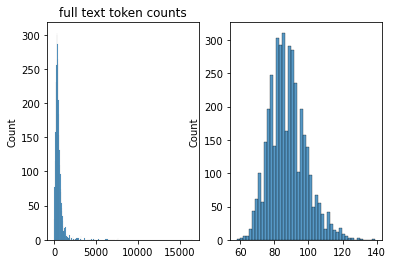

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(src_token_counts, ax=ax1)
ax1.set_title('full text token counts')
sns.histplot(tgt_token_counts, ax=ax2)

In [14]:
N_EPOCHS = 2
BATCH_SIZE = 2
data_module = PrepareDataset(train_df=train_df, test_df=test_df, tokenizer=tokenizer)
data_module.setup()


In [15]:
class AbstractiveSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
    
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [20]:
model = AbstractiveSummaryModel()

In [17]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [18]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Epoch 0, global step 494: val_loss reached 1.37950 (best 1.37950), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 1, global step 989: val_loss reached 1.36831 (best 1.36831), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


1

In [21]:
trained_model = AbstractiveSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trained_model.freeze()

In [22]:
def summarizeText(text):
    source_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = trained_model.model.generate(
        input_ids=source_encoding['input_ids'],
        attention_mask=source_encoding['attention_mask'],
        max_length=150,
        num_beams=1,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [23]:
import pickle

In [24]:
filename = open('text_summarization_model.pkl', 'wb')
pickle.dump(trained_model.model, filename)

In [25]:
model = pickle.load(open('text_summarization_model.pkl', 'rb'))

In [26]:
def summarizeText(text):
    source_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = model.generate(
        input_ids=source_encoding['input_ids'],
        attention_mask=source_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [33]:
src_test=test_df['text'].tolist()
eval_test=test_df['summary'].tolist()

In [34]:
!zip -r model.zip text_summarization_model.pkl


  adding: text_summarization_model.pkl (deflated 9%)


In [35]:
from google.colab import files
files.download("model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
pred_test=[]
for record in src_test:
  summary=summarizeText(record)
  pred_test.append(summary)

In [27]:
!pip install rouge

In [37]:
from rouge import Rouge 
rouge = Rouge()
scores = rouge.get_scores(eval_test, pred_test, avg=True)

In [39]:
scores

{'rouge-1': {'f': 0.4589199781881032,
  'p': 0.46123244416790665,
  'r': 0.4610470276443038},
 'rouge-2': {'f': 0.24472143209685807,
  'p': 0.24606398668808452,
  'r': 0.24585694352866164},
 'rouge-l': {'f': 0.42893343735141914,
  'p': 0.4312545727046945,
  'r': 0.4314404809878015}}

In [40]:
scores_ind = rouge.get_scores(eval_test, pred_test)

In [63]:
data_score=pd.DataFrame.from_dict(scores_ind)
data_score['text']=src_test
data_score['summary']=eval_test
data_score['pred']=pred_test
data_score.to_csv("data_score.csv")

In [64]:
data_score=pd.concat([data_score, pd.DataFrame(data_score['rouge-1'].tolist())], axis=1)

**SAMPLE SUMMARIZED DATA**

In [65]:
data_score.head()

rouge-1  ...         r
0  {'f': 0.5468749950305177, 'p': 0.5932203389830508, 'r': 0.5072463768115942}    ...  0.507246
1  {'f': 0.38181817683305785, 'p': 0.40384615384615385, 'r': 0.3620689655172414}  ...  0.362069
2  {'f': 0.44444443948979595, 'p': 0.49122807017543857, 'r': 0.4057971014492754}  ...  0.405797
3  {'f': 0.6949152492387246, 'p': 0.7068965517241379, 'r': 0.6833333333333333}    ...  0.683333
4  {'f': 0.3833333283555556, 'p': 0.4107142857142857, 'r': 0.359375}              ...  0.359375

[5 rows x 9 columns]

**5 SUMMARIZATION WITH LEAST SCORE**

In [67]:
data_score.nsmallest(5, 'f')

,rouge-1,rouge-2,rouge-l,text,summary,pred,f,p,r
331,"{'f': 0.13592232534640414, 'p': 0.1111111111111111, 'r': 0.175}","{'f': 0.019801975457309242, 'p': 0.016129032258064516, 'r': 0.02564102564102564}","{'f': 0.0898876357278124, 'p': 0.07272727272727272, 'r': 0.11764705882352941}","Ever since its inception, Chiranjeevi troops have been waiting with bated breath to see the megastar making a comeback after a 10-year hiatus. Khaidi No 150 Cast: Chiranjeevi, Kajal Aggarwal, Tarun Arora and Brahmanandam Khaidi No 150 Director: VV VinayakKhaidi No 150 Rating: (3/5)Despite the blockbuster film that Kaththi was, Chiranjeevi has to be appreciated for choosing a remake as his comeback to films. Being at the helm of a remake is like attracting the last nail to one's own coffin as it invariably compels the audience to get into unnecessary comparisons. ALSO READ: Chiranjeevi on Khaidi No 150- I'm not nervous, but curiousALSO READ: Chiranjeevi on Naga Babu-RGV fight- I was hurt, but I didn't reactHowever, director VV Vinayak makes no mistake with Khaidi No 150. Barring a few scenes and songs, the film is a frame-by-frame rendition of the Tamil version.Much like its original, the film introduces Kaththi Seenu (Chiranjeevi), an inmate of a Kolkata prison, trying to escape from the cops. The director shows Seenu's prison number (150), pauses for a few seconds, and then reveals Megastar's face. This customary introduction scene sees a chest-thumping reception from the Telugu circuit; after all, they've been dying to see him for years.As for the plot, a petty thief Kaththi Seenu discovers his badly wounded doppelganger Shankar (also Chiranjeevi) and decides to disguise himself as the latter to escape from the Kolkata police.When the plot slowly unfolds, Seenu gets to know about Shankar, a hydrologist, who is fighting against a corporate tycoon Aggarwal (Tarun Arora). Aggarwal attempts to draw groundwater from the Neeruru village to further his business. He's also to be blamed for the many farmer suicides.After learning the actual reason behind farmer suicides, Seenu and Aggarwal face off in this commercial yet socially relevant entertainer.Apart from the mass moments in the film, what deserves a special mention is Murugadoss's writing. While rampant issues like farmer suicides barely make for front page news, films like Khaidi No 150 or Kaththi pokes the audience's conscience. Films in this genre cater to a larger sect if it manages to deliver entertainment with a veiled social angle in it. In that sense, Khaidi No 150 is a win-win, even if the film is only about half as riveting compared to Chiranjeevi's Rudraveena (1988). There's a superb portion where the director criticises the mainstream media for having failed to address issues like farmer suicide. Some of the scenes have been purposely written to target the masses.Be it dialogue delivery or dancing, Chiranjeevi gives a stellar performance in dual roles. What's amusing about the actor is that even at 61, his age is hardly visible on screen. His son and actor Ram Charan, who has also produced the film, has a guest appearance in the song Ammadu Let's Do Kummudu. It goes without saying that Chiranjeevi's forte is dance and he's flexible with moves even after all these years. Ace comedians Ali and Brahmanandam provide the comic relief in Khaidi No 150.Samantha played the female lead in the Tamil version, while Kajal Aggarwal plays the role in Telugu. Though it's almost necessary to have a heroine on board, we wonder why both the actors were cast in their respective projects.One of the highlights of both the films is the coin fight scene. But the only difference is that while Vijay beat 80 goons to a pulp in Kaththi, the number is multiplied by 10 in its Telugu version. Because, Chiranjeevi. Neil Nitin Mukesh gave a commendable performance as the antagonist in Kaththi. Unfortunately, Tarun Arora is too funny to be taken seriously here.Khaidi No 150 has music by rockstar Devi Sri Prasad. The mak

**5 SUMMARIZATION WITH MORE SCORE**

In [68]:
data_score.nlargest(5, 'f')

,rouge-1,rouge-2,rouge-l,text,summary,pred,f,p,r
89,"{'f': 0.823529406765059, 'p': 0.8166666666666667, 'r': 0.8305084745762712}","{'f': 0.7008546958550662, 'p': 0.6949152542372882, 'r': 0.7068965517241379}","{'f': 0.849056598773585, 'p': 0.8490566037735849, 'r': 0.8490566037735849}","The Bombay high court has granted compensation of Rs2lakh to a 63-year-old murder convict from Aurangabad because he was kept in jail for three years and nine months beyond his sentence. A division bench of justices TV Nalawade and Sunil Kotwal directed the government to pay the amount to Ranjitsingh Gill within 45 days, failing which it would have to shell out interest at the rate of 12% a year. Gill was arrested in August 1975 on murder charges. He was acquitted by a trial court but the Bombay high court overturned the order and sentenced him to life imprisonment. The high court order was later upheld by the Supreme Court. After serving 17 years and nine months in jail, Gill was released in February 2002. Two years later, he approached the high court, seeking compensation of Rs25 lakh on the grounds that he was illegally detained for three years and nine months beyond the term of his sentence. Though the court agreed that section 433A (giving powers to state to commute or remit sentence)?of the Criminal Procedure Code, which came into effect three years after his conviction, was not applicable in this case, it said that the government had failed to release him on time. ?This court holds that compensation needs to be paid to the petitioner,? ruled the court. ?On the date he submitted his petition, the petitioner was about 50-year-old and it can be said that he lost more than three years of his active life owing to the illegal detention,? said the bench. ?When a person is kept behind bars, his entire family suffers. In our society, the male member is generally the main earner of the family,? it observedREADBombay high court irked with state?s cap on compensation for rape survivors at ?3 lakhBombay high court asks state to compensate student who lost MBBS seat to college irregularities","The Bombay High Court granted a compensation of ?2 lakh to a 63-year-old murder convict as he was illegally detained in jail for three years and nine months beyond his sentence. A bench of justices directed the government to pay him within 45 days, failing which it would have to shell out interest at the rate of 12% a year.","The Bombay High Court has granted compensation of?2 lakh to a 63-year-old murder convict from Aurangabad because he was kept in jail for three years and nine months beyond his sentence. The court directed the government to pay the amount within 45 days, failing which it would have to shell out interest at the rate of 12% a year.",0.823529,0.816667,0.830508
203,"{'f': 0.81739129937845, 'p': 0.8867924528301887, 'r': 0.7580645161290323}","{'f': 0.6902654817573812, 'p': 0.75, 'r': 0.639344262295082}","{'f': 0.8199999950180001, 'p': 0.8723404255319149, 'r': 0.7735849056603774}","A Chennai-based NGO today filed a Public Interest Litigation (PIL) in the Supreme Court demanding a CBI probe into the death of former Tamil Nadu Chief Minister J Jayalalithaa.The petition has also asked for the recovery of all medical documents during the AIADMK chief's stay in Chennai's Apollo Hospital for more than two months.Jayalalithaa, 68, died of cardiac arrest on December 5. Her stay in Apollo since September 22 was marked by secrecy, forcing many to ask questions about her health and the future of the AIADMK.ALSO READ: What exactly happened to Jayalalithaa? We got this from doctors who know Last week, senior Tamil actor Gautami Tadimalla had written to Prime Minister Narendra Modi, raising questions about the ""secrecy"" maintained by the Tamil Nadu government during Jayalalithaa's treatment.ALSO READ: How did Jayalalithaa die? Tamil actor Gautami Tadimalla writes to PM Modi for answers",A Chennai-based NGO has filed a Public Interest Litigation (PIL) in the Supre

**PROCESSING AMAZON DATASET**

In [52]:
amazon_review=pd.read_csv("amazon_review.csv")
hyps=amazon_review['Summary'].tolist()
refs=amazon_review['Text'].tolist()
pred_test_amazon=[]
for record in refs:
  summary=summarizeText(record)
  pred_test_amazon.append(summary)
#hyps, refs = map(list, zip(*[[amazon_review['Summary'], amazon_review['Text']]]))
scores = rouge.get_scores(hyps, refs)
amazon_score=pd.DataFrame(scores)
amazon_score['summary']=hyps
amazon_score['text']=refs
amazon_score['pred']=pred_test_amazon
amazon_score.to_csv("amazon_score.csv")
scores_avg = rouge.get_scores(hyps, refs, avg=True)

In [55]:
scores_avg

{'rouge-1': {'f': 0.05909964940117048,
  'p': 0.26551948051948054,
  'r': 0.03423567348555467},
 'rouge-2': {'f': 0.01987382432380469,
  'p': 0.10892857142857143,
  'r': 0.011222411894318588},
 'rouge-l': {'f': 0.06547612086213551,
  'p': 0.2642857142857143,
  'r': 0.03838984354487787}}

In [56]:
pd.set_option("display.max_colwidth", -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [58]:
amazon_score.head()

,rouge-1,rouge-2,rouge-l,summary,text,pred
0,"{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0, 'p': 0.0, 'r': 0.0}",Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,My Labrador loves the canned dog food Vitality canning product. It looks more like a stew than a processed meat and it smells better. She is finicky and she appreciates this product better than most.
1,"{'f': 0.11428571271836736, 'p': 0.6666666666666666, 'r': 0.0625}","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.12903225631633716, 'p': 0.6666666666666666, 'r': 0.07142857142857142}",Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".","The peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"". I'm not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"{'f': 0.020202019426589155, 'p': 0.25, 'r': 0.010526315789473684}","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0270270260043828, 'p': 0.25, 'r': 0.014285714285714285}","""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.","A confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. Not too chewy, and very flavorful."
3,"{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0, 'p': 0.0, 'r': 0.0}",Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,"The secret ingredient in Robitussin is a root beer extract, which I ordered and made some cherry soda. It has a very medicinal flavor and the taste is very medicinal."
4,"{'f': 0.13793103319857317, 'p': 1.0, 'r': 0.07407407407407407}","{'f': 0.07407407336076818, 'p': 1.0, 'r': 0.038461538461538464}","{'f': 0.17391304189035917, 'p': 1.0, 'r': 0.09523809523809523}",Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",The taffy was very good and the delivery was quick. I would recommend this store to anyone who is a taffy lover.
